In [1]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.signal import savgol_filter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, RNN, Dropout, Dense
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D, Input
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Model
import math
import matplotlib.pyplot as plt
import seaborn as sns

2023-11-24 13:37:56.260853: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-24 13:37:56.290494: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-24 13:37:56.291367: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-24 13:37:56.784236: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
results_df = pd.DataFrame()

# Plotting data

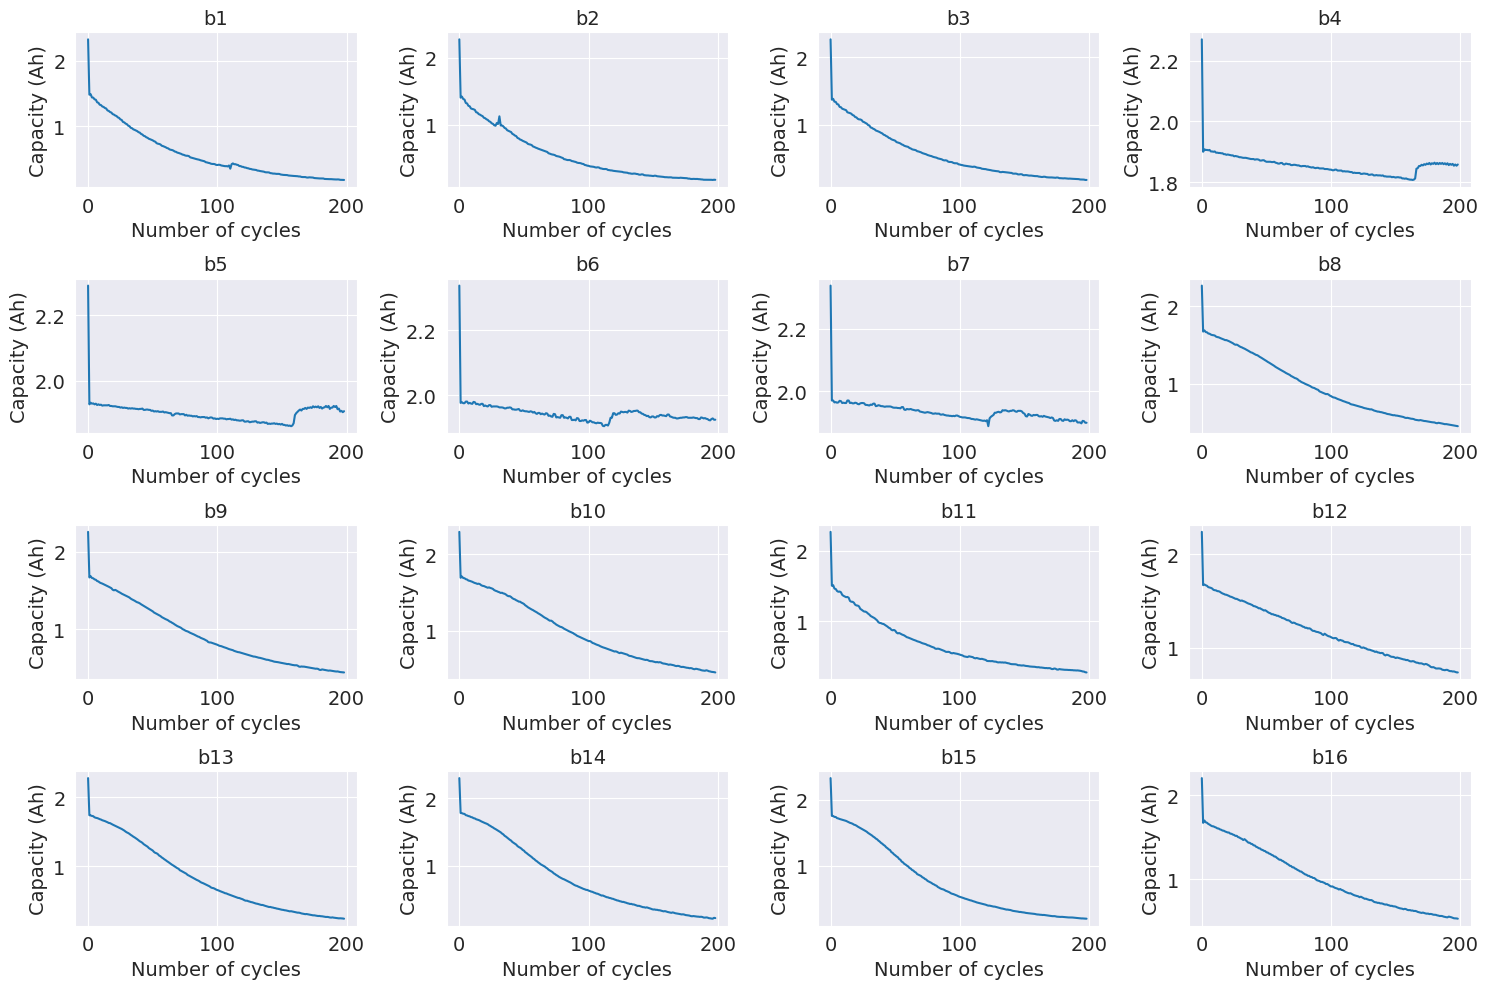

In [5]:
# Load the data
with open('combined_capacity_data.json', 'r') as fp:
    qd_capacity_dict = json.load(fp)

# Set the number of rows and columns for the subplot grid
rows, cols = 4, 4

# Create the subplots
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 10))

# Loop over all axes to plot random data
for i in range(rows):
    for j in range(cols):
        # Generate random data
        b_id = f"b{4*i+j+1}"
        battery_data = qd_capacity_dict[b_id]

        # Plot on the current axis
        axes[i, j].plot(battery_data)
        axes[i, j].set_title(b_id, fontsize=14)
        axes[i, j].tick_params(axis='x', labelsize=14)  # Adjust xticks size
        axes[i, j].tick_params(axis='y', labelsize=14)  # Adjust xticks size
        axes[i, j].set_xlabel('Number of cycles', fontsize=14) 
        axes[i, j].set_ylabel('Capacity (Ah)', fontsize=14) 

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plots
plt.show()



# # Filtering and cutting
# for battery_id in qd_capacity_dict.keys():
#     plt.figure()
#     battery_data = np.array(qd_capacity_dict[battery_id])
#     plt.plot(battery_data)
#     plt.suptitle(battery_id)
#     qd_capacity_dict[battery_id] = battery_data[10:]


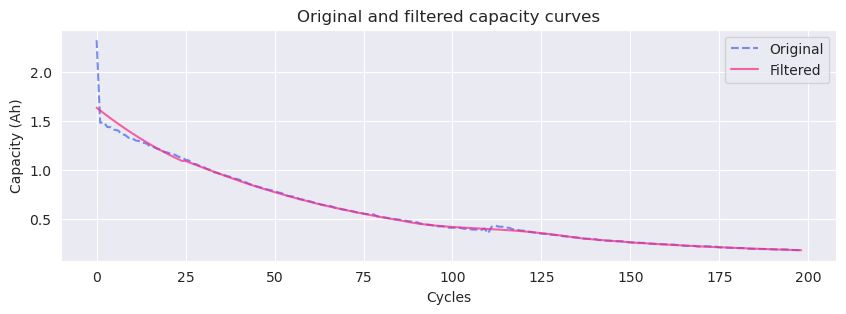

In [19]:
# Plot original and savgol data
with open('combined_capacity_data_edited.json', 'r') as fp:
    qd_capacity_dict = json.load(fp)

# Filtering and cutting
for battery_id in qd_capacity_dict.keys():
    battery_data = np.array(qd_capacity_dict[battery_id])
    filtered_data = savgol_filter(battery_data, 50, 2)
    qd_capacity_dict[battery_id] = filtered_data[10:]
    
    plt.figure(figsize=(10, 3))
    sns.set_style('darkgrid')
    sns.lineplot(battery_data[:len(filtered_data)], label='Original', alpha=0.7, linestyle='--', color='#4361EE')
    sns.lineplot(filtered_data, label='Filtered', alpha=0.7, color='#F72585')
    
    # sns.lineplot(x=cycle_indices[hops:len(battery_data)], y=combined_capacity[hops:len(battery_data)], label='Predicted Capacity', alpha=0.7, color='#F72585')
    # plt.plot(battery_data[:200, 0], label='Actual Capacity (200 Cycles)', alpha=0.7, linestyle='--', color='green')
    # plt.plot(cycle_indices[:hops], battery_data[:hops, 0], label='Initial Cycles', alpha=0.7)
    plt.title(f'Original and filtered capacity curves')
    plt.xlabel('Cycles')
    plt.ylabel('Capacity (Ah)')
    plt.legend()
    plt.show()

    break

# Normal data LSTM

In [3]:
# Load the data
with open('combined_capacity_data_edited.json', 'r') as fp:
    qd_capacity_dict = json.load(fp)

# Filtering and cutting
for battery_id in qd_capacity_dict.keys():
    battery_data = np.array(qd_capacity_dict[battery_id])
    qd_capacity_dict[battery_id] = battery_data[10:]

# Split the battery IDs into training and testing sets
battery_ids = list(qd_capacity_dict.keys())
train_ids, test_ids = train_test_split(battery_ids, test_size=0.2, random_state=42)

# Initialize variables for training data
X_train = []
y_train = []
hops = 50
forecast_steps = 50

# Prepare training data using filtered and sliced battery data
for battery_id in train_ids:
    battery_data = qd_capacity_dict[battery_id]
    for i in range(hops, len(battery_data) - forecast_steps):
        X_train.append(battery_data[i - hops:i])
        y_train.append(battery_data[i:i + forecast_steps])

# Reshape for LSTM input
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(forecast_steps))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=75, batch_size=32)


2023-11-23 11:31:40.436575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-23 11:31:40.436939: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-23 11:31:40.437254: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/75
28/28 [==============================] - 2s 21ms/step - loss: 0.1697
Epoch 2/75
28/28 [==============================] - 1s 22ms/step - loss: 0.0346
Epoch 3/75
28/28 [==============================] - 1s 24ms/step - loss: 0.0203
Epoch 4/75
28/28 [==============================] - 1s 20ms/step - loss: 0.0166
Epoch 5/75
28/28 [==============================] - 0s 14ms/step - loss: 0.0140
Epoch 6/75
28/28 [==============================] - 1s 21ms/step - loss: 0.0119
Epoch 7/75
28/28 [==============================] - 1s 24ms/step - loss: 0.0110
Epoch 8/75
28/28 [==============================] - 1s 21ms/step - loss: 0.0104
Epoch 9/75
28/28 [==============================] - 1s 22ms/step - loss: 0.0087
Epoch 10/75
28/28 [==============================] - 1s 23ms/step - loss: 0.0087
Epoch 11/75
28/28 [==============================] - 1s 23ms/step - loss: 0.0080
Epoch 12/75
28/28 [==============================] - 0s 15ms/step - loss: 0.0079
Epoch 13/75
28/28 [==================

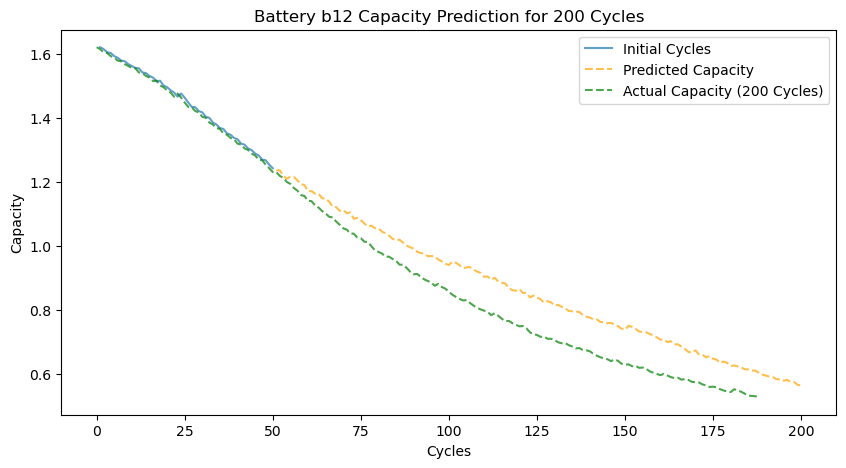

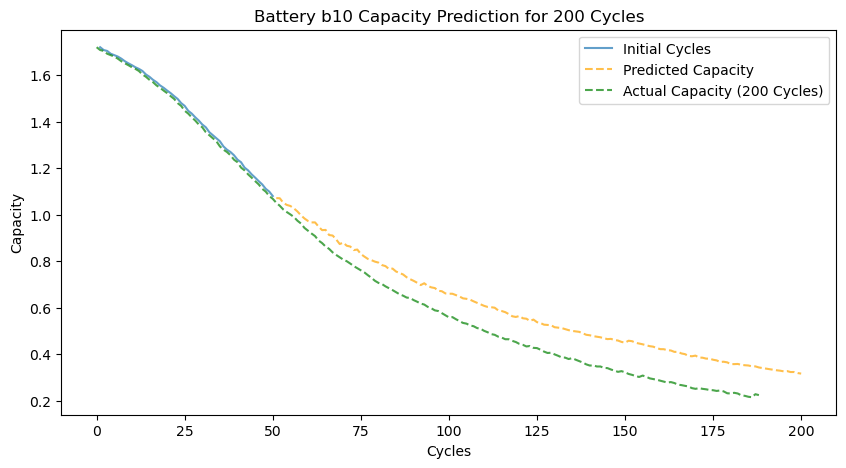

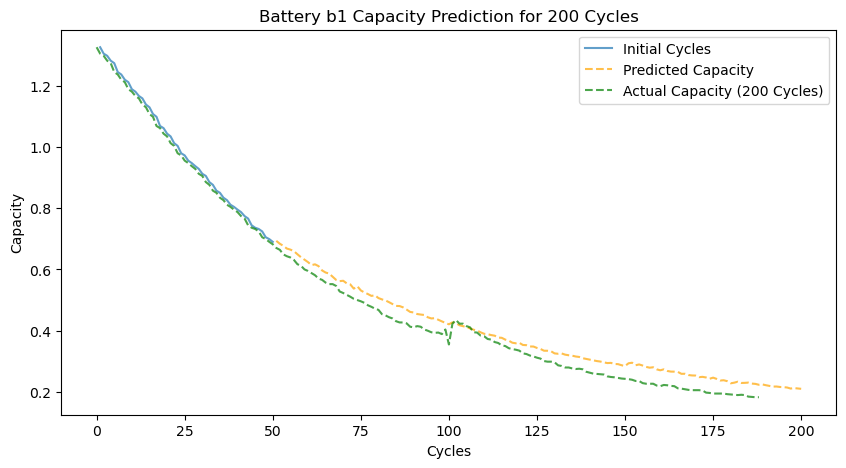

In [4]:
# Prepare the testing data
X_test = []
y_test = []

for battery_id in test_ids:
    battery_data = np.array(qd_capacity_dict[battery_id])
    for i in range(hops, len(battery_data) - forecast_steps):
        X_test.append(battery_data[i - hops:i])
        y_test.append(battery_data[i:i + forecast_steps])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

rmse_multiforecast_list = []

# Prediction code
for i, battery_id in enumerate(test_ids):
    battery_data = np.array(qd_capacity_dict[battery_id]).reshape(-1, 1)
    input_sequence = battery_data[:hops, 0]

    predictions = []
    cycle_count = 0  # Initialize cycle count

    while cycle_count < (200 - hops):
        model_input = np.reshape(input_sequence, (1, -1, 1))
        predicted_cycles = model.predict(model_input, verbose=0).flatten()

        predictions.extend(predicted_cycles)
        input_sequence = np.append(input_sequence[len(predicted_cycles):], predicted_cycles)

        cycle_count += len(predicted_cycles)

    combined_capacity = np.concatenate((battery_data[:hops, 0], predictions))

    cycle_indices = np.arange(1, len(combined_capacity) + 1)

    final_y = battery_data[hops:, 0]
    rmse_multiforecast = np.sqrt(mean_squared_error(final_y, predictions[:len(final_y)]))
    rmse_multiforecast_list.append(rmse_multiforecast)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(cycle_indices[:hops], battery_data[:hops, 0], label='Initial Cycles', alpha=0.7)
    plt.plot(cycle_indices[hops:200], combined_capacity[hops:200], label='Predicted Capacity', alpha=0.7, linestyle='--', color='orange')
    plt.plot(battery_data[:200, 0], label='Actual Capacity (200 Cycles)', alpha=0.7, linestyle='--', color='green')
    plt.title(f'Battery {battery_id} Capacity Prediction for 200 Cycles')
    plt.xlabel('Cycles')
    plt.ylabel('Capacity')
    plt.legend()
    plt.show()


In [5]:
y_pred = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_pred, y_train))
results_df.loc["normal_LSTM", "train"] = rmse_train

y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_pred, y_test))
results_df.loc["normal_LSTM", "test"] = rmse_test

results_df.loc["normal_LSTM", "multi_forecast"] = np.mean(rmse_multiforecast_list)

28/28 [==============================] - 0s 4ms/step


9/9 [==============================] - 0s 4ms/step


In [6]:
results_df

,train,test,multi_forecast
normal_LSTM,0.026488,0.029358,0.07586


# Savgol LSTM

In [7]:
# Load the data
with open('combined_capacity_data_edited.json', 'r') as fp:
    qd_capacity_dict = json.load(fp)

# Filtering and cutting
for battery_id in qd_capacity_dict.keys():
    battery_data = np.array(qd_capacity_dict[battery_id])
    filtered_data = savgol_filter(battery_data, 50, 2)
    qd_capacity_dict[battery_id] = filtered_data[10:]

# Split the battery IDs into training and testing sets
battery_ids = list(qd_capacity_dict.keys())
train_ids, test_ids = train_test_split(battery_ids, test_size=0.2, random_state=42)

# Initialize variables for training data
X_train = []
y_train = []
hops = 50
forecast_steps = 50

# Prepare training data using filtered and sliced battery data
for battery_id in train_ids:
    battery_data = qd_capacity_dict[battery_id]
    for i in range(hops, len(battery_data) - forecast_steps):
        X_train.append(battery_data[i - hops:i])
        y_train.append(battery_data[i:i + forecast_steps])

# Reshape for LSTM input
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(forecast_steps))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=75, batch_size=32)


Epoch 1/75
28/28 [==============================] - 2s 25ms/step - loss: 0.1775
Epoch 2/75
28/28 [==============================] - 1s 19ms/step - loss: 0.0367
Epoch 3/75
28/28 [==============================] - 1s 19ms/step - loss: 0.0231
Epoch 4/75
28/28 [==============================] - 1s 22ms/step - loss: 0.0187
Epoch 5/75
28/28 [==============================] - 0s 16ms/step - loss: 0.0159
Epoch 6/75
28/28 [==============================] - 0s 13ms/step - loss: 0.0143
Epoch 7/75
28/28 [==============================] - 0s 16ms/step - loss: 0.0125
Epoch 8/75
28/28 [==============================] - 1s 23ms/step - loss: 0.0107
Epoch 9/75
28/28 [==============================] - 1s 26ms/step - loss: 0.0103
Epoch 10/75
28/28 [==============================] - 0s 13ms/step - loss: 0.0088
Epoch 11/75
28/28 [==============================] - 0s 18ms/step - loss: 0.0088
Epoch 12/75
28/28 [==============================] - 1s 22ms/step - loss: 0.0078
Epoch 13/75
28/28 [==================

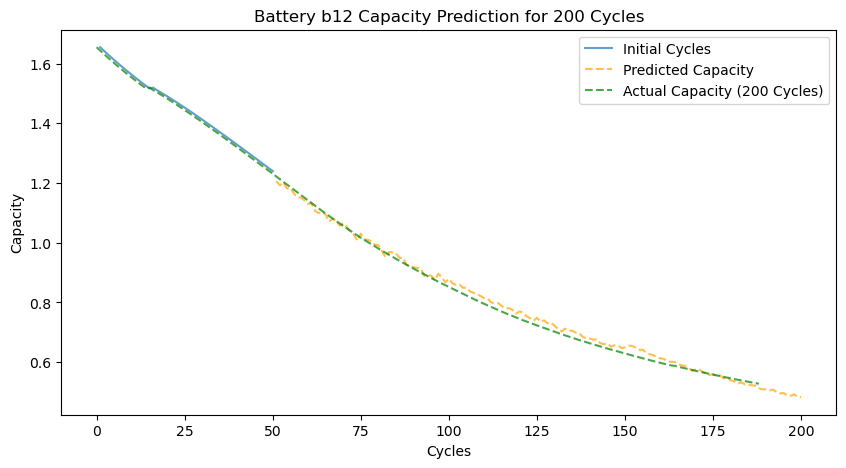

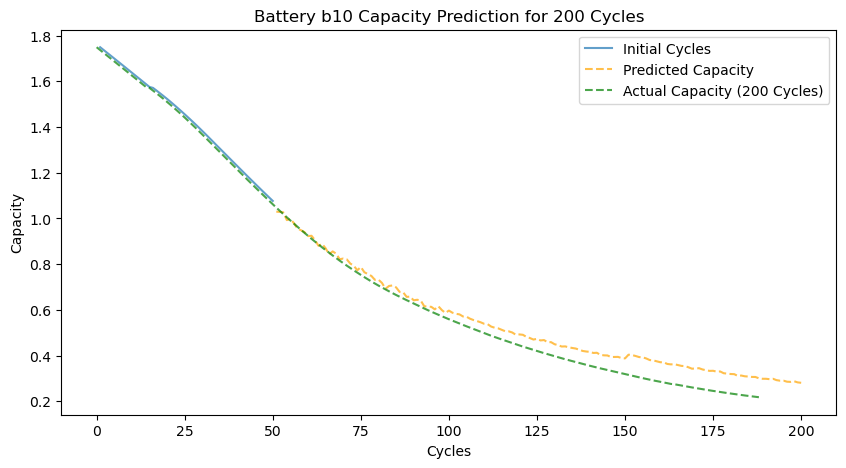

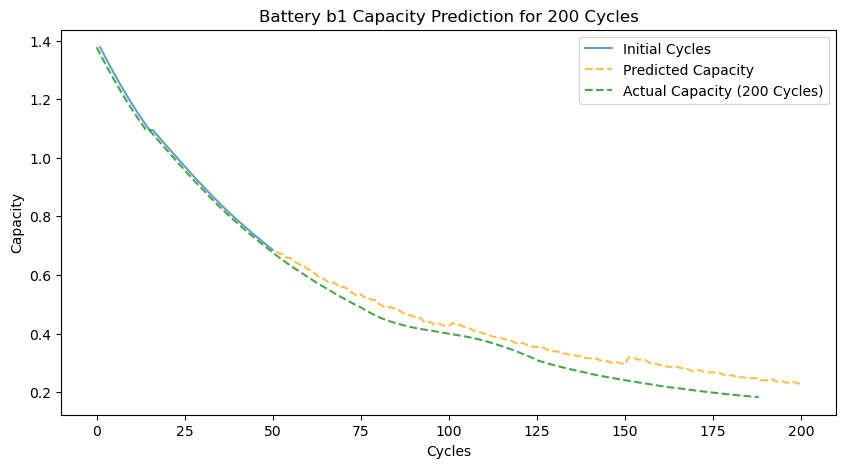

In [8]:
# Prepare the testing data
X_test = []
y_test = []

for battery_id in test_ids:
    battery_data = np.array(qd_capacity_dict[battery_id])
    for i in range(hops, len(battery_data) - forecast_steps):
        X_test.append(battery_data[i - hops:i])
        y_test.append(battery_data[i:i + forecast_steps])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

rmse_multiforecast_list = []

# Prediction code
for i, battery_id in enumerate(test_ids):
    battery_data = np.array(qd_capacity_dict[battery_id]).reshape(-1, 1)
    input_sequence = battery_data[:hops, 0]

    predictions = []
    cycle_count = 0  # Initialize cycle count

    while cycle_count < (200 - hops):
        model_input = np.reshape(input_sequence, (1, -1, 1))
        predicted_cycles = model.predict(model_input, verbose=0).flatten()

        predictions.extend(predicted_cycles)
        input_sequence = np.append(input_sequence[len(predicted_cycles):], predicted_cycles)

        cycle_count += len(predicted_cycles)

    combined_capacity = np.concatenate((battery_data[:hops, 0], predictions))

    cycle_indices = np.arange(1, len(combined_capacity) + 1)

    final_y = battery_data[hops:, 0]
    rmse_multiforecast = np.sqrt(mean_squared_error(final_y, predictions[:len(final_y)]))
    rmse_multiforecast_list.append(rmse_multiforecast)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(cycle_indices[:hops], battery_data[:hops, 0], label='Initial Cycles', alpha=0.7)
    plt.plot(cycle_indices[hops:200], combined_capacity[hops:200], label='Predicted Capacity', alpha=0.7, linestyle='--', color='orange')
    plt.plot(battery_data[:200, 0], label='Actual Capacity (200 Cycles)', alpha=0.7, linestyle='--', color='green')
    plt.title(f'Battery {battery_id} Capacity Prediction for 200 Cycles')
    plt.xlabel('Cycles')
    plt.ylabel('Capacity')
    plt.legend()
    plt.show()


In [9]:
y_pred = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_pred, y_train))
results_df.loc["savgol_LSTM", "train"] = rmse_train

y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_pred, y_test))
results_df.loc["savgol_LSTM", "test"] = rmse_test

results_df.loc["savgol_LSTM", "multi_forecast"] = np.mean(rmse_multiforecast_list)

25/28 [=========================>....] - ETA: 0s

9/9 [==============================] - 0s 5ms/step


In [10]:
results_df

,train,test,multi_forecast
normal_LSTM,0.026488,0.029358,0.075860
savgol_LSTM,0.023066,0.023664,0.038182


# Normal GRU

In [11]:
# Load the data
with open('combined_capacity_data_edited.json', 'r') as fp:
    qd_capacity_dict = json.load(fp)

# Filtering and cutting
for battery_id in qd_capacity_dict.keys():
    battery_data = np.array(qd_capacity_dict[battery_id])
    qd_capacity_dict[battery_id] = battery_data[10:]

# Split the battery IDs into training and testing sets
battery_ids = list(qd_capacity_dict.keys())
train_ids, test_ids = train_test_split(battery_ids, test_size=0.2, random_state=42)

# Initialize variables for training data
X_train = []
y_train = []
hops = 50
forecast_steps = 50

# Prepare training data using filtered and sliced battery data
for battery_id in train_ids:
    battery_data = qd_capacity_dict[battery_id]
    for i in range(hops, len(battery_data) - forecast_steps):
        X_train.append(battery_data[i - hops:i])
        y_train.append(battery_data[i:i + forecast_steps])

# Reshape for LSTM input
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(GRU(units=50))
model.add(Dropout(0.2))
model.add(Dense(forecast_steps))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=75, batch_size=32)
model.save_weights('./checkpoints/GRU_normal_epochs75')

Epoch 1/75


28/28 [==============================] - 2s 24ms/step - loss: 0.1838
Epoch 2/75
28/28 [==============================] - 1s 23ms/step - loss: 0.0387
Epoch 3/75
28/28 [==============================] - 1s 25ms/step - loss: 0.0216
Epoch 4/75
28/28 [==============================] - 1s 28ms/step - loss: 0.0178
Epoch 5/75
28/28 [==============================] - 1s 21ms/step - loss: 0.0149
Epoch 6/75
28/28 [==============================] - 1s 20ms/step - loss: 0.0134
Epoch 7/75
28/28 [==============================] - 1s 25ms/step - loss: 0.0118
Epoch 8/75
28/28 [==============================] - 1s 27ms/step - loss: 0.0117
Epoch 9/75
28/28 [==============================] - 0s 16ms/step - loss: 0.0117
Epoch 10/75
28/28 [==============================] - 0s 16ms/step - loss: 0.0106
Epoch 11/75
28/28 [==============================] - 1s 22ms/step - loss: 0.0098
Epoch 12/75
28/28 [==============================] - 1s 26ms/step - loss: 0.0092
Epoch 13/75
28/28 [=============================

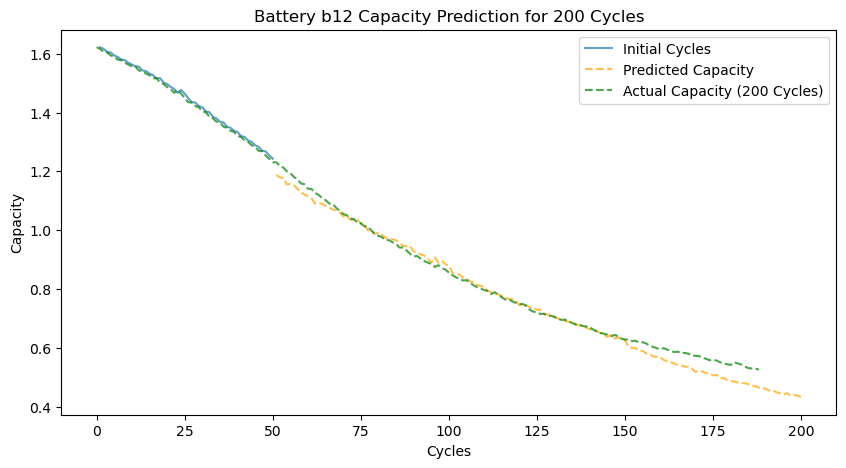

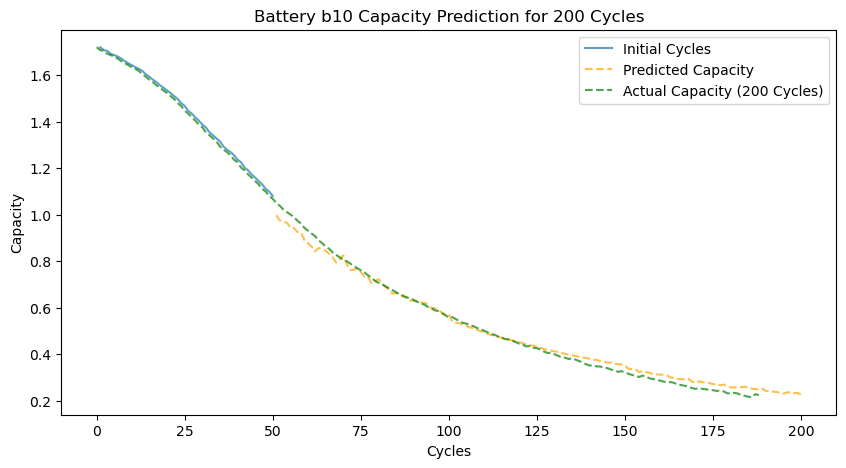

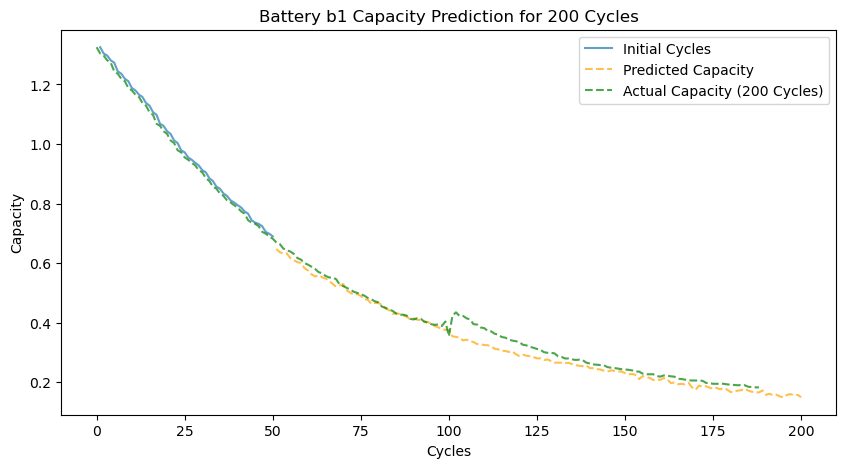

In [12]:
# Prepare the testing data
X_test = []
y_test = []

for battery_id in test_ids:
    battery_data = np.array(qd_capacity_dict[battery_id])
    for i in range(hops, len(battery_data) - forecast_steps):
        X_test.append(battery_data[i - hops:i])
        y_test.append(battery_data[i:i + forecast_steps])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

rmse_multiforecast_list = []

# Prediction code
for i, battery_id in enumerate(test_ids):
    battery_data = np.array(qd_capacity_dict[battery_id]).reshape(-1, 1)
    input_sequence = battery_data[:hops, 0]

    predictions = []
    cycle_count = 0  # Initialize cycle count

    while cycle_count < (200 - hops):
        model_input = np.reshape(input_sequence, (1, -1, 1))
        predicted_cycles = model.predict(model_input, verbose=0).flatten()

        predictions.extend(predicted_cycles)
        input_sequence = np.append(input_sequence[len(predicted_cycles):], predicted_cycles)

        cycle_count += len(predicted_cycles)

    combined_capacity = np.concatenate((battery_data[:hops, 0], predictions))

    cycle_indices = np.arange(1, len(combined_capacity) + 1)

    final_y = battery_data[hops:, 0]
    rmse_multiforecast = np.sqrt(mean_squared_error(final_y, predictions[:len(final_y)]))
    rmse_multiforecast_list.append(rmse_multiforecast)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(cycle_indices[:hops], battery_data[:hops, 0], label='Initial Cycles', alpha=0.7)
    plt.plot(cycle_indices[hops:200], combined_capacity[hops:200], label='Predicted Capacity', alpha=0.7, linestyle='--', color='orange')
    plt.plot(battery_data[:200, 0], label='Actual Capacity (200 Cycles)', alpha=0.7, linestyle='--', color='green')
    plt.title(f'Battery {battery_id} Capacity Prediction for 200 Cycles')
    plt.xlabel('Cycles')
    plt.ylabel('Capacity')
    plt.legend()
    plt.show()


In [13]:
y_pred = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_pred, y_train))
results_df.loc["normal_GRU", "train"] = rmse_train

y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_pred, y_test))
results_df.loc["normal_GRU", "test"] = rmse_test

results_df.loc["normal_GRU", "multi_forecast"] = np.mean(rmse_multiforecast_list)

1/9 [==>...........................] - ETA: 0s

9/9 [==============================] - 0s 4ms/step


In [14]:
results_df

,train,test,multi_forecast
normal_LSTM,0.026488,0.029358,0.075860
savgol_LSTM,0.023066,0.023664,0.038182
normal_GRU,0.028331,0.031374,0.029218


# Savgol GRU

In [15]:
# Load the data
with open('combined_capacity_data_edited.json', 'r') as fp:
    qd_capacity_dict = json.load(fp)

# Filtering and cutting
for battery_id in qd_capacity_dict.keys():
    battery_data = np.array(qd_capacity_dict[battery_id])
    filtered_data = savgol_filter(battery_data, 50, 2)
    qd_capacity_dict[battery_id] = filtered_data[10:]

# Split the battery IDs into training and testing sets
battery_ids = list(qd_capacity_dict.keys())
train_ids, test_ids = train_test_split(battery_ids, test_size=0.2, random_state=42)

# Initialize variables for training data
X_train = []
y_train = []
hops = 50
forecast_steps = 50

# Prepare training data using filtered and sliced battery data
for battery_id in train_ids:
    battery_data = qd_capacity_dict[battery_id]
    for i in range(hops, len(battery_data) - forecast_steps):
        X_train.append(battery_data[i - hops:i])
        y_train.append(battery_data[i:i + forecast_steps])

# Reshape for LSTM input
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(GRU(units=50))
model.add(Dropout(0.2))
model.add(Dense(forecast_steps))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=75, batch_size=32)
model.save_weights('./checkpoints/GRU_savgol_epochs75')

Epoch 1/75


28/28 [==============================] - 2s 23ms/step - loss: 0.1925
Epoch 2/75
28/28 [==============================] - 1s 28ms/step - loss: 0.0427
Epoch 3/75
28/28 [==============================] - 1s 24ms/step - loss: 0.0233
Epoch 4/75
28/28 [==============================] - 1s 25ms/step - loss: 0.0172
Epoch 5/75
28/28 [==============================] - 1s 26ms/step - loss: 0.0153
Epoch 6/75
28/28 [==============================] - 1s 26ms/step - loss: 0.0133
Epoch 7/75
28/28 [==============================] - 0s 18ms/step - loss: 0.0122
Epoch 8/75
28/28 [==============================] - 1s 25ms/step - loss: 0.0111
Epoch 9/75
28/28 [==============================] - 1s 24ms/step - loss: 0.0104
Epoch 10/75
28/28 [==============================] - 0s 17ms/step - loss: 0.0096
Epoch 11/75
28/28 [==============================] - 1s 20ms/step - loss: 0.0097
Epoch 12/75
28/28 [==============================] - 1s 22ms/step - loss: 0.0092
Epoch 13/75
28/28 [=============================

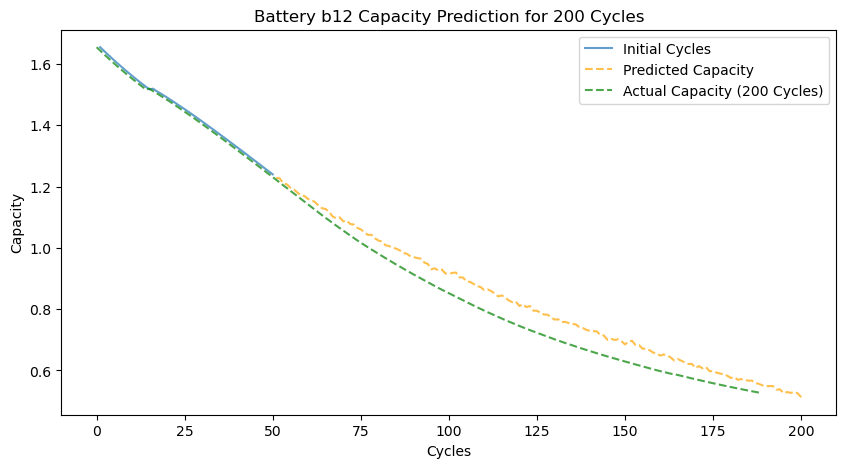

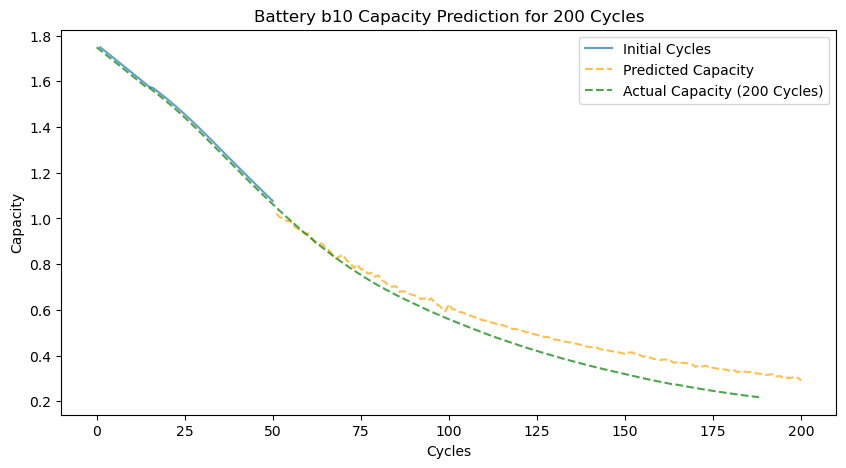

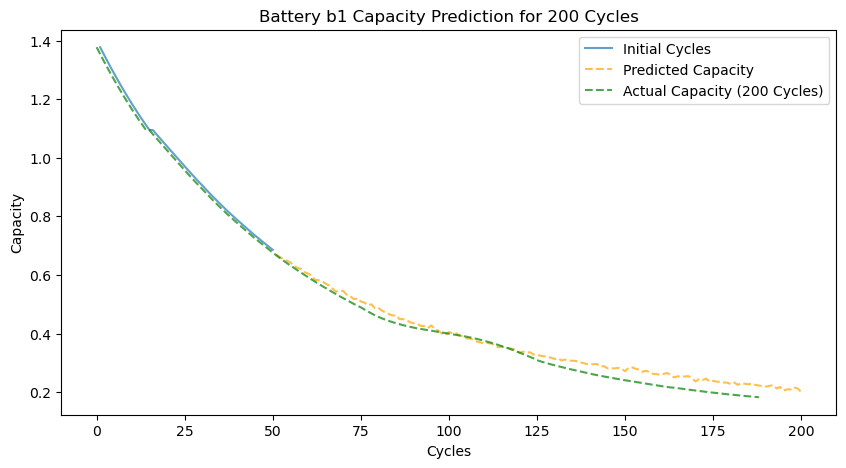

In [16]:
# Prepare the testing data
X_test = []
y_test = []

for battery_id in test_ids:
    battery_data = np.array(qd_capacity_dict[battery_id])
    for i in range(hops, len(battery_data) - forecast_steps):
        X_test.append(battery_data[i - hops:i])
        y_test.append(battery_data[i:i + forecast_steps])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

rmse_multiforecast_list = []

# Prediction code
for i, battery_id in enumerate(test_ids):
    battery_data = np.array(qd_capacity_dict[battery_id]).reshape(-1, 1)
    input_sequence = battery_data[:hops, 0]

    predictions = []
    cycle_count = 0  # Initialize cycle count

    while cycle_count < (200 - hops):
        model_input = np.reshape(input_sequence, (1, -1, 1))
        predicted_cycles = model.predict(model_input, verbose=0).flatten()

        predictions.extend(predicted_cycles)
        input_sequence = np.append(input_sequence[len(predicted_cycles):], predicted_cycles)

        cycle_count += len(predicted_cycles)

    combined_capacity = np.concatenate((battery_data[:hops, 0], predictions))

    cycle_indices = np.arange(1, len(combined_capacity) + 1)

    final_y = battery_data[hops:, 0]
    rmse_multiforecast = np.sqrt(mean_squared_error(final_y, predictions[:len(final_y)]))
    rmse_multiforecast_list.append(rmse_multiforecast)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(cycle_indices[:hops], battery_data[:hops, 0], label='Initial Cycles', alpha=0.7)
    plt.plot(cycle_indices[hops:200], combined_capacity[hops:200], label='Predicted Capacity', alpha=0.7, linestyle='--', color='orange')
    plt.plot(battery_data[:200, 0], label='Actual Capacity (200 Cycles)', alpha=0.7, linestyle='--', color='green')
    plt.title(f'Battery {battery_id} Capacity Prediction for 200 Cycles')
    plt.xlabel('Cycles')
    plt.ylabel('Capacity')
    plt.legend()
    plt.show()


In [17]:
y_pred = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_pred, y_train))
results_df.loc["savgol_GRU", "train"] = rmse_train

y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_pred, y_test))
results_df.loc["savgol_GRU", "test"] = rmse_test

results_df.loc["savgol_GRU", "multi_forecast"] = np.mean(rmse_multiforecast_list)

25/28 [=========================>....] - ETA: 0s

9/9 [==============================] - 0s 4ms/step


In [18]:
results_df

,train,test,multi_forecast
normal_LSTM,0.026488,0.029358,0.075860
savgol_LSTM,0.023066,0.023664,0.038182
normal_GRU,0.028331,0.031374,0.029218
savgol_GRU,0.015913,0.019333,0.047518


# Normal data RNN

In [19]:
# Load the data
with open('combined_capacity_data_edited.json', 'r') as fp:
    qd_capacity_dict = json.load(fp)

# Filtering and cutting
for battery_id in qd_capacity_dict.keys():
    battery_data = np.array(qd_capacity_dict[battery_id])
    filtered_data = savgol_filter(battery_data, 50, 2)
    qd_capacity_dict[battery_id] = filtered_data[10:]

# Split the battery IDs into training and testing sets
battery_ids = list(qd_capacity_dict.keys())
train_ids, test_ids = train_test_split(battery_ids, test_size=0.2, random_state=42)

# Initialize variables for training data
X_train = []
y_train = []
hops = 50
forecast_steps = 50

# Prepare training data using filtered and sliced battery data
for battery_id in train_ids:
    battery_data = qd_capacity_dict[battery_id]
    for i in range(hops, len(battery_data) - forecast_steps):
        X_train.append(battery_data[i - hops:i])
        y_train.append(battery_data[i:i + forecast_steps])

# Reshape for RNN input
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50))
model.add(Dropout(0.2))
model.add(Dense(forecast_steps))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=75, batch_size=32)

Epoch 1/75


28/28 [==============================] - 1s 10ms/step - loss: 0.2567
Epoch 2/75
28/28 [==============================] - 0s 11ms/step - loss: 0.0711
Epoch 3/75
28/28 [==============================] - 0s 12ms/step - loss: 0.0376
Epoch 4/75
28/28 [==============================] - 0s 14ms/step - loss: 0.0289
Epoch 5/75
28/28 [==============================] - 0s 9ms/step - loss: 0.0238
Epoch 6/75
28/28 [==============================] - 0s 9ms/step - loss: 0.0208
Epoch 7/75
28/28 [==============================] - 0s 13ms/step - loss: 0.0188
Epoch 8/75
28/28 [==============================] - 0s 13ms/step - loss: 0.0172
Epoch 9/75
28/28 [==============================] - 0s 13ms/step - loss: 0.0151
Epoch 10/75
28/28 [==============================] - 0s 12ms/step - loss: 0.0139
Epoch 11/75
28/28 [==============================] - 0s 13ms/step - loss: 0.0129
Epoch 12/75
28/28 [==============================] - 0s 8ms/step - loss: 0.0116
Epoch 13/75
28/28 [==============================] 

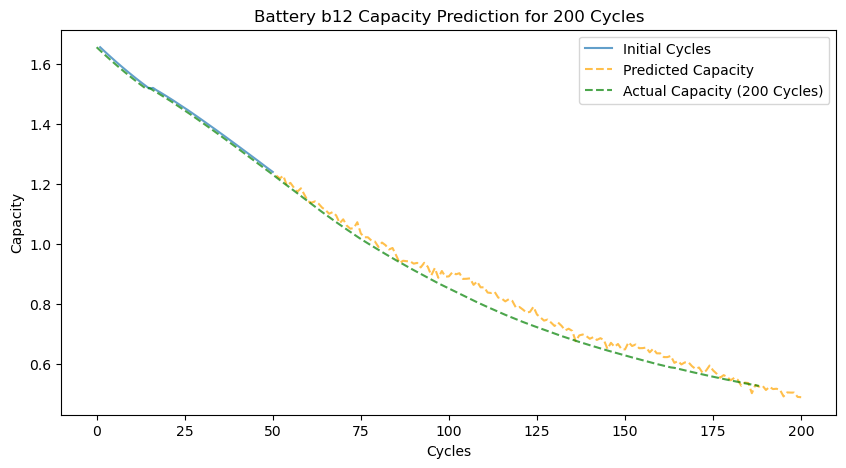

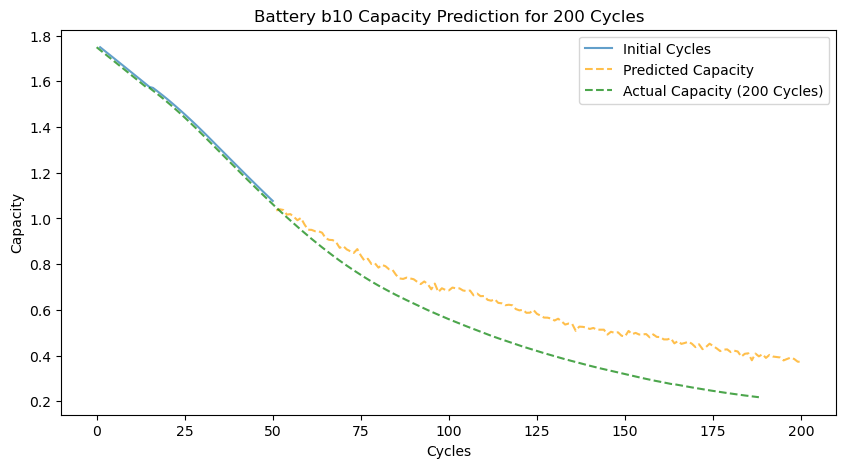

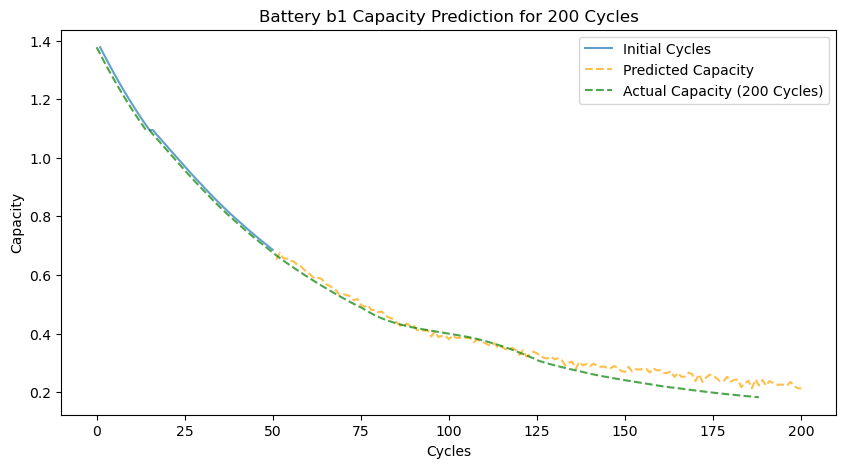

In [20]:
# Prepare the testing data
X_test = []
y_test = []

for battery_id in test_ids:
    battery_data = np.array(qd_capacity_dict[battery_id])
    for i in range(hops, len(battery_data) - forecast_steps):
        X_test.append(battery_data[i - hops:i])
        y_test.append(battery_data[i:i + forecast_steps])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

rmse_multiforecast_list = []

# Prediction code
for i, battery_id in enumerate(test_ids):
    battery_data = np.array(qd_capacity_dict[battery_id]).reshape(-1, 1)
    input_sequence = battery_data[:hops, 0]

    predictions = []
    cycle_count = 0  # Initialize cycle count

    while cycle_count < (200 - hops):
        model_input = np.reshape(input_sequence, (1, -1, 1))
        predicted_cycles = model.predict(model_input, verbose=0).flatten()

        predictions.extend(predicted_cycles)
        input_sequence = np.append(input_sequence[len(predicted_cycles):], predicted_cycles)

        cycle_count += len(predicted_cycles)

    combined_capacity = np.concatenate((battery_data[:hops, 0], predictions))

    cycle_indices = np.arange(1, len(combined_capacity) + 1)

    final_y = battery_data[hops:, 0]
    rmse_multiforecast = np.sqrt(mean_squared_error(final_y, predictions[:len(final_y)]))
    rmse_multiforecast_list.append(rmse_multiforecast)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(cycle_indices[:hops], battery_data[:hops, 0], label='Initial Cycles', alpha=0.7)
    plt.plot(cycle_indices[hops:200], combined_capacity[hops:200], label='Predicted Capacity', alpha=0.7, linestyle='--', color='orange')
    plt.plot(battery_data[:200, 0], label='Actual Capacity (200 Cycles)', alpha=0.7, linestyle='--', color='green')
    plt.title(f'Battery {battery_id} Capacity Prediction for 200 Cycles')
    plt.xlabel('Cycles')
    plt.ylabel('Capacity')
    plt.legend()
    plt.show()


In [21]:
y_pred = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_pred, y_train))
results_df.loc["normal_RNN", "train"] = rmse_train

y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_pred, y_test))
results_df.loc["normal_RNN", "test"] = rmse_test

results_df.loc["normal_RNN", "multi_forecast"] = np.mean(rmse_multiforecast_list)

9/9 [==============================] - 0s 2ms/step


In [22]:
results_df

,train,test,multi_forecast
normal_LSTM,0.026488,0.029358,0.075860
savgol_LSTM,0.023066,0.023664,0.038182
normal_GRU,0.028331,0.031374,0.029218
savgol_GRU,0.015913,0.019333,0.047518
normal_RNN,0.026032,0.026908,0.066297


# Savgol RNN

In [23]:
# Load the data
with open('combined_capacity_data_edited.json', 'r') as fp:
    qd_capacity_dict = json.load(fp)

# Filtering and cutting
for battery_id in qd_capacity_dict.keys():
    battery_data = np.array(qd_capacity_dict[battery_id])
    filtered_data = savgol_filter(battery_data, 50, 2)
    qd_capacity_dict[battery_id] = filtered_data[10:]

# Split the battery IDs into training and testing sets
battery_ids = list(qd_capacity_dict.keys())
train_ids, test_ids = train_test_split(battery_ids, test_size=0.2, random_state=42)

# Initialize variables for training data
X_train = []
y_train = []
hops = 50
forecast_steps = 50

# Prepare training data using filtered and sliced battery data
for battery_id in train_ids:
    battery_data = qd_capacity_dict[battery_id]
    for i in range(hops, len(battery_data) - forecast_steps):
        X_train.append(battery_data[i - hops:i])
        y_train.append(battery_data[i:i + forecast_steps])

# Reshape for RNN input
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50))
model.add(Dropout(0.2))
model.add(Dense(forecast_steps))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=75, batch_size=32)

Epoch 1/75


28/28 [==============================] - 1s 9ms/step - loss: 0.3010
Epoch 2/75
28/28 [==============================] - 0s 11ms/step - loss: 0.0838
Epoch 3/75
28/28 [==============================] - 0s 11ms/step - loss: 0.0415
Epoch 4/75
28/28 [==============================] - 0s 11ms/step - loss: 0.0328
Epoch 5/75
28/28 [==============================] - 0s 11ms/step - loss: 0.0281
Epoch 6/75
28/28 [==============================] - 0s 10ms/step - loss: 0.0235
Epoch 7/75
28/28 [==============================] - 0s 13ms/step - loss: 0.0206
Epoch 8/75
28/28 [==============================] - 0s 7ms/step - loss: 0.0191
Epoch 9/75
28/28 [==============================] - 0s 10ms/step - loss: 0.0172
Epoch 10/75
28/28 [==============================] - 0s 11ms/step - loss: 0.0157
Epoch 11/75
28/28 [==============================] - 0s 12ms/step - loss: 0.0150
Epoch 12/75
28/28 [==============================] - 0s 12ms/step - loss: 0.0142
Epoch 13/75
28/28 [==============================]

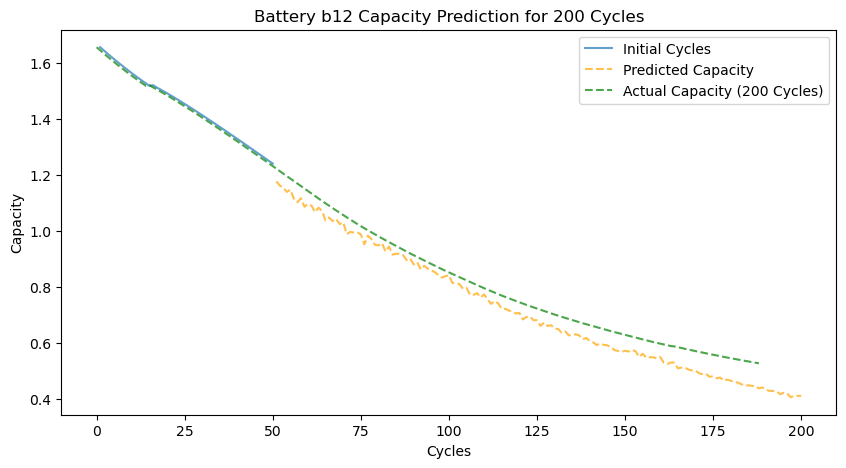

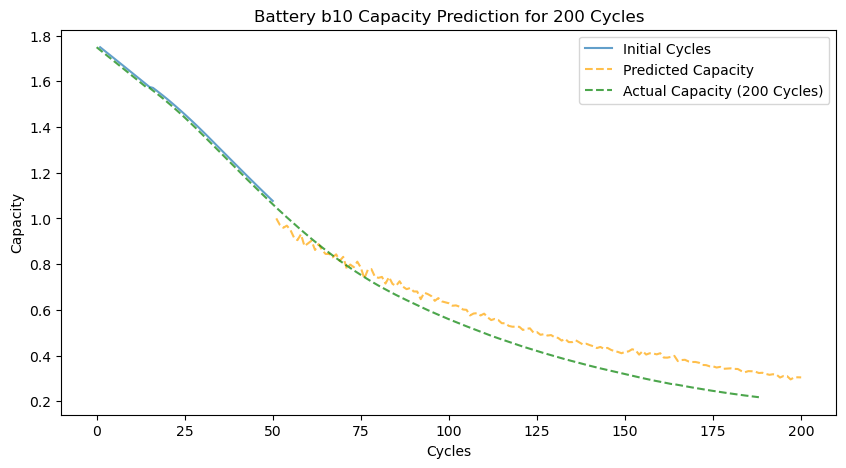

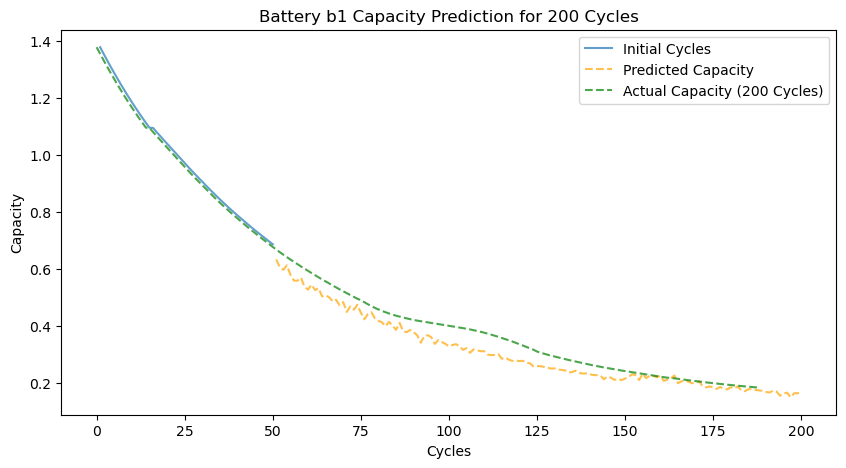

In [24]:
# Prepare the testing data
X_test = []
y_test = []

for battery_id in test_ids:
    battery_data = np.array(qd_capacity_dict[battery_id])
    for i in range(hops, len(battery_data) - forecast_steps):
        X_test.append(battery_data[i - hops:i])
        y_test.append(battery_data[i:i + forecast_steps])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

rmse_multiforecast_list = []

# Prediction code
for i, battery_id in enumerate(test_ids):
    battery_data = np.array(qd_capacity_dict[battery_id]).reshape(-1, 1)
    input_sequence = battery_data[:hops, 0]

    predictions = []
    cycle_count = 0  # Initialize cycle count

    while cycle_count < (200 - hops):
        model_input = np.reshape(input_sequence, (1, -1, 1))
        predicted_cycles = model.predict(model_input, verbose=0).flatten()

        predictions.extend(predicted_cycles)
        input_sequence = np.append(input_sequence[len(predicted_cycles):], predicted_cycles)

        cycle_count += len(predicted_cycles)

    combined_capacity = np.concatenate((battery_data[:hops, 0], predictions))

    cycle_indices = np.arange(1, len(combined_capacity) + 1)

    final_y = battery_data[hops:, 0]
    rmse_multiforecast = np.sqrt(mean_squared_error(final_y, predictions[:len(final_y)]))
    rmse_multiforecast_list.append(rmse_multiforecast)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(cycle_indices[:hops], battery_data[:hops, 0], label='Initial Cycles', alpha=0.7)
    plt.plot(cycle_indices[hops:200], combined_capacity[hops:200], label='Predicted Capacity', alpha=0.7, linestyle='--', color='orange')
    plt.plot(battery_data[:200, 0], label='Actual Capacity (200 Cycles)', alpha=0.7, linestyle='--', color='green')
    plt.title(f'Battery {battery_id} Capacity Prediction for 200 Cycles')
    plt.xlabel('Cycles')
    plt.ylabel('Capacity')
    plt.legend()
    plt.show()


In [25]:
y_pred = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_pred, y_train))
results_df.loc["savgol_RNN", "train"] = rmse_train

y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_pred, y_test))
results_df.loc["savgol_RNN", "test"] = rmse_test

results_df.loc["savgol_RNN", "multi_forecast"] = np.mean(rmse_multiforecast_list)

28/28 [==============================] - 0s 2ms/step


9/9 [==============================] - 0s 2ms/step


In [26]:
results_df

,train,test,multi_forecast
normal_LSTM,0.026488,0.029358,0.075860
savgol_LSTM,0.023066,0.023664,0.038182
normal_GRU,0.028331,0.031374,0.029218
savgol_GRU,0.015913,0.019333,0.047518
normal_RNN,0.026032,0.026908,0.066297
savgol_RNN,0.036980,0.038024,0.061193


# Normal 1D CNN

In [27]:
# Load the data
with open('combined_capacity_data_edited.json', 'r') as fp:
    qd_capacity_dict = json.load(fp)

# Filtering and cutting
for battery_id in qd_capacity_dict.keys():
    battery_data = np.array(qd_capacity_dict[battery_id])
    filtered_data = savgol_filter(battery_data, 50, 2)
    qd_capacity_dict[battery_id] = filtered_data[10:]

# Split the battery IDs into training and testing sets
battery_ids = list(qd_capacity_dict.keys())
train_ids, test_ids = train_test_split(battery_ids, test_size=0.2, random_state=42)

# Initialize variables for training data
X_train = []
y_train = []
hops = 50
forecast_steps = 50

# Prepare training data using filtered and sliced battery data
for battery_id in train_ids:
    battery_data = qd_capacity_dict[battery_id]
    for i in range(hops, len(battery_data) - forecast_steps):
        X_train.append(battery_data[i - hops:i])
        y_train.append(battery_data[i:i + forecast_steps])

# Reshape for RNN input
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

def make_cnn_model(kernel_size):
    # Build the RNN model
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Conv1D(filters=64, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(forecast_steps))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model1 = make_cnn_model(2)
model2 = make_cnn_model(3)
model3 = make_cnn_model(5)
model4 = make_cnn_model(10)

# Train the model
model1.fit(X_train, y_train, epochs=200, batch_size=32)
model2.fit(X_train, y_train, epochs=200, batch_size=32)
model3.fit(X_train, y_train, epochs=200, batch_size=32)
model4.fit(X_train, y_train, epochs=200, batch_size=32)

Epoch 1/200


28/28 [==============================] - 0s 1ms/step - loss: 0.2221
Epoch 2/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0354
Epoch 3/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0131
Epoch 4/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0104
Epoch 5/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0091
Epoch 6/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0084
Epoch 7/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0080
Epoch 8/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0069
Epoch 9/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0057
Epoch 10/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0047
Epoch 11/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0040
Epoch 12/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 13/200
28/28 [=============================

In [28]:
# Prepare the testing data
X_test = []
y_test = []

for battery_id in test_ids:
    battery_data = np.array(qd_capacity_dict[battery_id])
    for i in range(hops, len(battery_data) - forecast_steps):
        X_test.append(battery_data[i - hops:i])
        y_test.append(battery_data[i:i + forecast_steps])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [29]:
results_cnn = pd.DataFrame()

models = [(model1, 2), (model2, 3), (model3, 5), (model4, 10)]

for model, ks in models:
    y_pred = model.predict(X_train)
    rmse_train = mean_squared_error(y_pred, y_train)
    results_cnn.loc[f"cnn_ks{ks}", "train"] = rmse_train

    y_pred = model.predict(X_test)
    rmse_test = mean_squared_error(y_pred, y_test)
    results_cnn.loc[f"cnn_ks{ks}", "test"] = rmse_test

# y_pred = model.predict(X_train)
# rmse_train = mean_squared_error(y_pred, y_train)
# results_df.loc["normal_RNN", "train"] = rmse_train

# y_pred = model.predict(X_test)
# rmse_test = mean_squared_error(y_pred, y_test)
# results_df.loc["normal_RNN", "test"] = rmse_test

9/9 [==============================] - 0s 631us/step


9/9 [==============================] - 0s 600us/step


In [30]:
results_cnn
# Best cnn: ks=2

,train,test
cnn_ks2,0.000275,0.000612
cnn_ks3,0.000263,0.000625
cnn_ks5,0.000344,0.000789
cnn_ks10,0.000168,0.000569


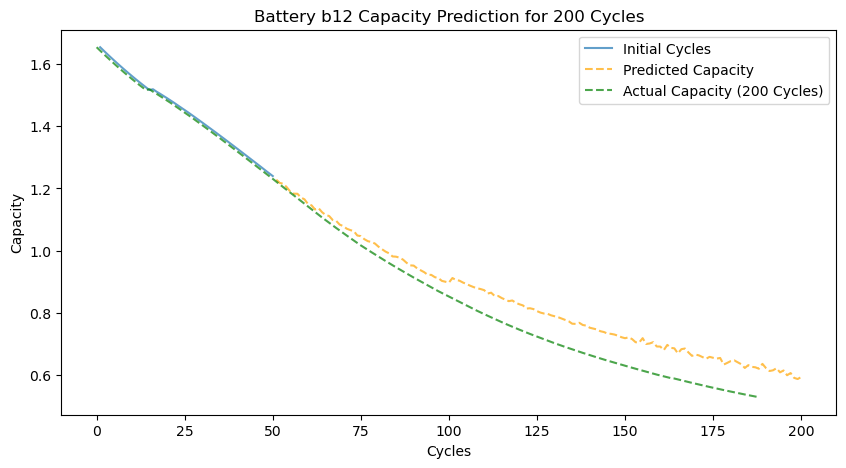

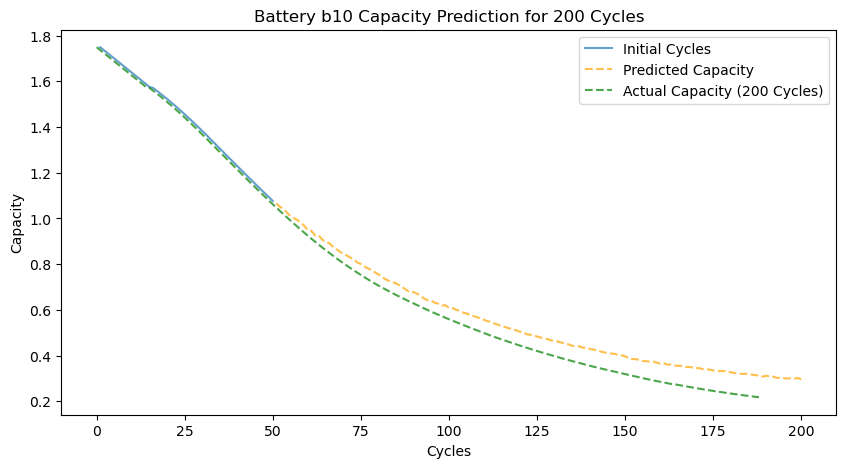

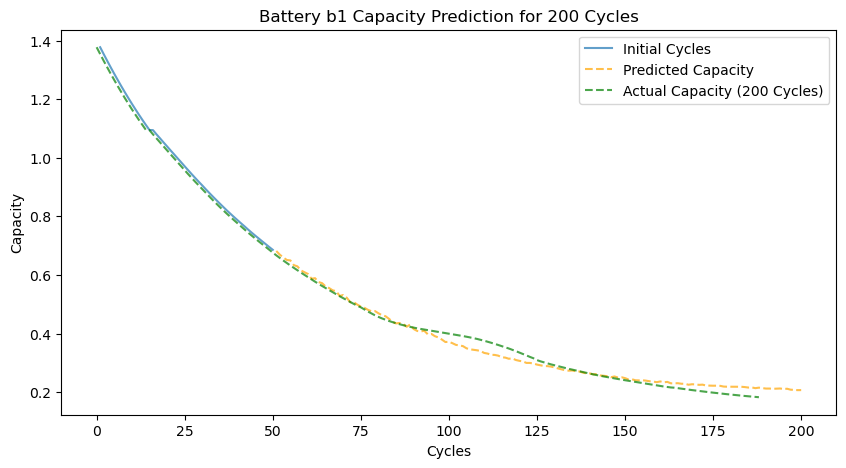

In [31]:
# Prepare the testing data
X_test = []
y_test = []

for battery_id in test_ids:
    battery_data = np.array(qd_capacity_dict[battery_id])
    for i in range(hops, len(battery_data) - forecast_steps):
        X_test.append(battery_data[i - hops:i])
        y_test.append(battery_data[i:i + forecast_steps])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

rmse_multiforecast_list = []

model = model1

# Prediction code
for i, battery_id in enumerate(test_ids):
    battery_data = np.array(qd_capacity_dict[battery_id]).reshape(-1, 1)
    input_sequence = battery_data[:hops, 0]

    predictions = []
    cycle_count = 0  # Initialize cycle count

    while cycle_count < (200 - hops):
        model_input = np.reshape(input_sequence, (1, -1, 1))
        predicted_cycles = model.predict(model_input, verbose=0).flatten()

        predictions.extend(predicted_cycles)
        input_sequence = np.append(input_sequence[len(predicted_cycles):], predicted_cycles)

        cycle_count += len(predicted_cycles)

    combined_capacity = np.concatenate((battery_data[:hops, 0], predictions))

    cycle_indices = np.arange(1, len(combined_capacity) + 1)

    final_y = battery_data[hops:, 0]
    rmse_multiforecast = np.sqrt(mean_squared_error(final_y, predictions[:len(final_y)]))
    rmse_multiforecast_list.append(rmse_multiforecast)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(cycle_indices[:hops], battery_data[:hops, 0], label='Initial Cycles', alpha=0.7)
    plt.plot(cycle_indices[hops:200], combined_capacity[hops:200], label='Predicted Capacity', alpha=0.7, linestyle='--', color='orange')
    plt.plot(battery_data[:200, 0], label='Actual Capacity (200 Cycles)', alpha=0.7, linestyle='--', color='green')
    plt.title(f'Battery {battery_id} Capacity Prediction for 200 Cycles')
    plt.xlabel('Cycles')
    plt.ylabel('Capacity')
    plt.legend()
    plt.show()


In [32]:
# for model, ks in models[3:]:
model, ks = models[0]

y_pred = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_pred, y_train))
results_df.loc[f"normal_cnn_ks{ks}", "train"] = rmse_train

y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_pred, y_test))
results_df.loc[f"normal_cnn_ks{ks}", "test"] = rmse_test

results_df.loc[f"normal_cnn_ks{ks}", "multi_forecast"] = np.mean(rmse_multiforecast_list)

9/9 [==============================] - 0s 636us/step


In [33]:
results_df

,train,test,multi_forecast
normal_LSTM,0.026488,0.029358,0.075860
savgol_LSTM,0.023066,0.023664,0.038182
normal_GRU,0.028331,0.031374,0.029218
savgol_GRU,0.015913,0.019333,0.047518
normal_RNN,0.026032,0.026908,0.066297
savgol_RNN,0.036980,0.038024,0.061193
normal_cnn_ks2,0.016575,0.024735,0.049995


# Savgol 1D CNN

In [38]:
# Load the data
with open('combined_capacity_data_edited.json', 'r') as fp:
    qd_capacity_dict = json.load(fp)

# Filtering and cutting
for battery_id in qd_capacity_dict.keys():
    battery_data = np.array(qd_capacity_dict[battery_id])
    filtered_data = savgol_filter(battery_data, 50, 2)
    qd_capacity_dict[battery_id] = filtered_data[10:]

# Split the battery IDs into training and testing sets
battery_ids = list(qd_capacity_dict.keys())
train_ids, test_ids = train_test_split(battery_ids, test_size=0.2, random_state=42)

# Initialize variables for training data
X_train = []
y_train = []
hops = 50
forecast_steps = 50

# Prepare training data using filtered and sliced battery data
for battery_id in train_ids:
    battery_data = qd_capacity_dict[battery_id]
    for i in range(hops, len(battery_data) - forecast_steps):
        X_train.append(battery_data[i - hops:i])
        y_train.append(battery_data[i:i + forecast_steps])

# Reshape for RNN input
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

def make_cnn_model(kernel_size):
    # Build the CNN model
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Conv1D(filters=64, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(forecast_steps))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Best model: ks = 2
model = make_cnn_model(2)

# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=32)

Epoch 1/200


28/28 [==============================] - 0s 1ms/step - loss: 0.1571
Epoch 2/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0208
Epoch 3/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0118
Epoch 4/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 5/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 6/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 7/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 8/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 9/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 10/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 11/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0057
Epoch 12/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 13/200
28/28 [=============================

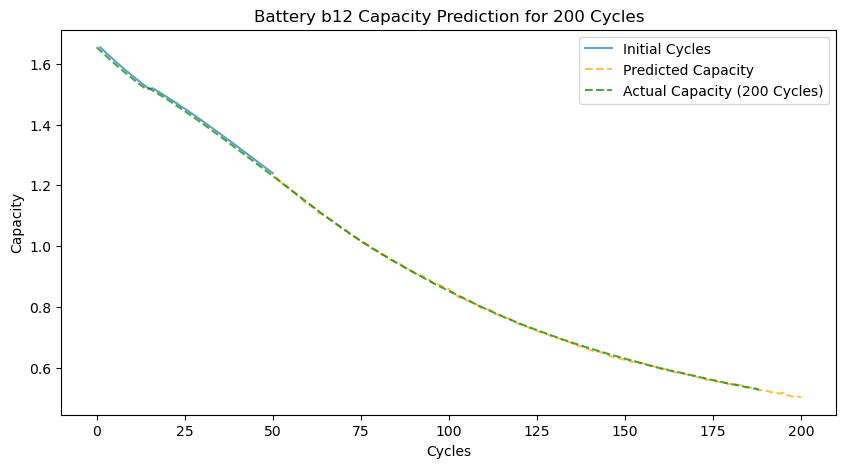

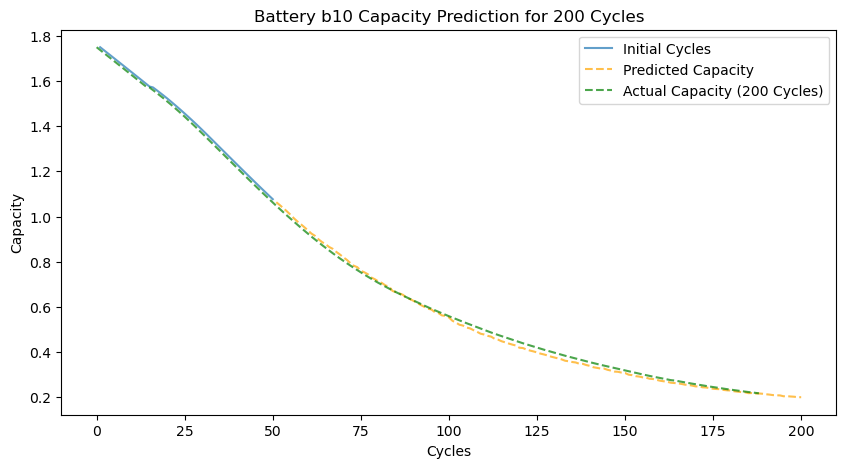

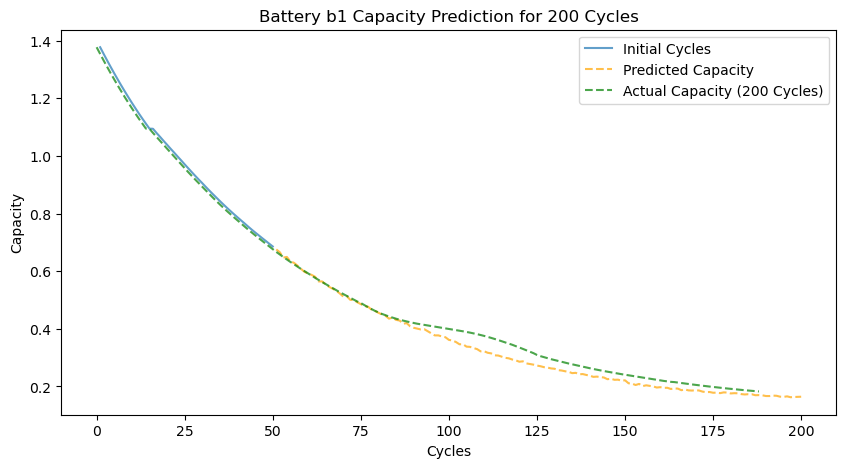

In [39]:
# Prepare the testing data
X_test = []
y_test = []

for battery_id in test_ids:
    battery_data = np.array(qd_capacity_dict[battery_id])
    filtered_data = savgol_filter(battery_data, 50, 2)
    for i in range(hops, len(filtered_data) - forecast_steps):
        X_test.append(filtered_data[i - hops:i])
        y_test.append(filtered_data[i:i + forecast_steps])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

rmse_multiforecast_list = []

# Prediction code
for i, battery_id in enumerate(test_ids):
    battery_data = np.array(qd_capacity_dict[battery_id]).reshape(-1, 1)
    input_sequence = battery_data[:hops, 0]

    predictions = []
    cycle_count = 0  # Initialize cycle count

    while cycle_count < (200 - hops):
        model_input = np.reshape(input_sequence, (1, -1, 1))
        predicted_cycles = model.predict(model_input, verbose=0).flatten()

        predictions.extend(predicted_cycles)
        input_sequence = np.append(input_sequence[len(predicted_cycles):], predicted_cycles)

        cycle_count += len(predicted_cycles)

    combined_capacity = np.concatenate((battery_data[:hops, 0], predictions))

    cycle_indices = np.arange(1, len(combined_capacity) + 1)

    final_y = battery_data[hops:, 0]
    rmse_multiforecast = np.sqrt(mean_squared_error(final_y, predictions[:len(final_y)]))
    rmse_multiforecast_list.append(rmse_multiforecast)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(cycle_indices[:hops], battery_data[:hops, 0], label='Initial Cycles', alpha=0.7)
    plt.plot(cycle_indices[hops:200], combined_capacity[hops:200], label='Predicted Capacity', alpha=0.7, linestyle='--', color='orange')
    plt.plot(battery_data[:200, 0], label='Actual Capacity (200 Cycles)', alpha=0.7, linestyle='--', color='green')
    plt.title(f'Battery {battery_id} Capacity Prediction for 200 Cycles')
    plt.xlabel('Cycles')
    plt.ylabel('Capacity')
    plt.legend()
    plt.show()


In [40]:
y_pred = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_pred, y_train))
results_df.loc[f"savgol_cnn_ks{ks}", "train"] = rmse_train

y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_pred, y_test))
results_df.loc[f"savgol_cnn_ks{ks}", "test"] = rmse_test

results_df.loc[f"savgol_cnn_ks{ks}", "multi_forecast"] = np.mean(rmse_multiforecast_list)

9/9 [==============================] - 0s 606us/step


In [41]:
results_df

,train,test,multi_forecast
normal_LSTM,0.026488,0.029358,0.075860
savgol_LSTM,0.023066,0.023664,0.038182
normal_GRU,0.028331,0.031374,0.029218
savgol_GRU,0.015913,0.019333,0.047518
normal_RNN,0.026032,0.026908,0.066297
savgol_RNN,0.036980,0.038024,0.061193
normal_cnn_ks2,0.016575,0.024735,0.049995
savgol_cnn_ks2,0.015263,0.021927,0.017485


In [ ]:
#model.save_weights('./checkpoints/best_1DCNN_savgol_epochs200_kernelsize2')

# Improving plots

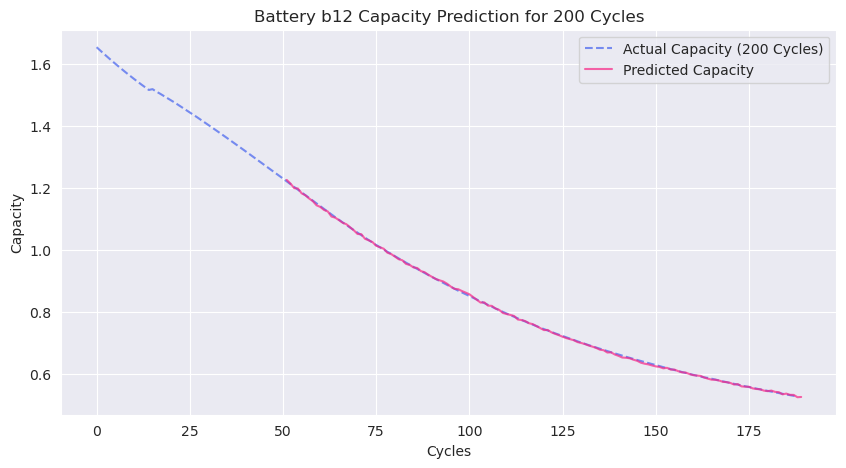

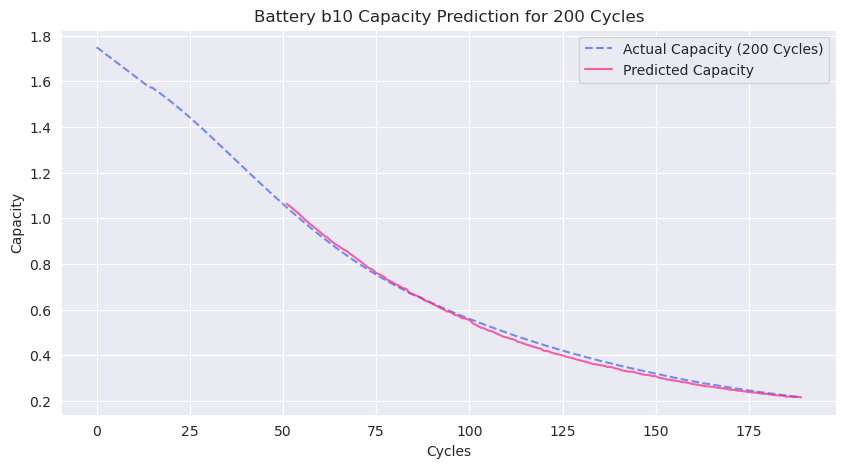

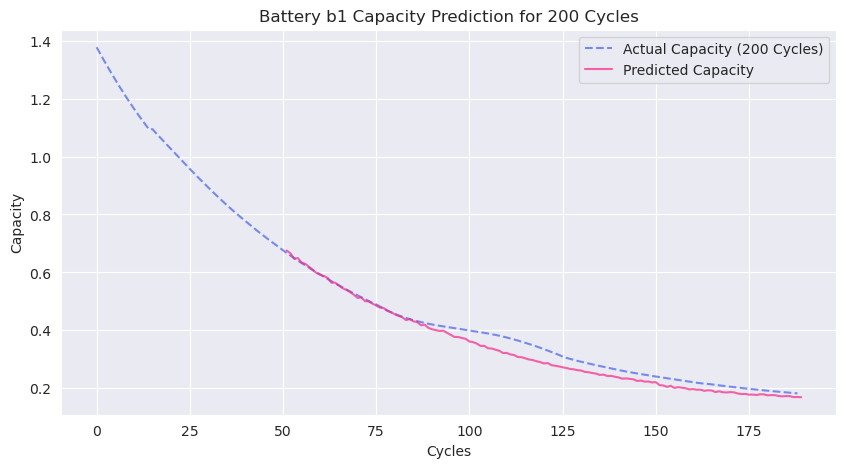

In [50]:
import seaborn as sns

# Prepare the testing data
X_test = []
y_test = []

for battery_id in test_ids:
    battery_data = np.array(qd_capacity_dict[battery_id])
    filtered_data = savgol_filter(battery_data, 50, 2)
    for i in range(hops, len(filtered_data) - forecast_steps):
        X_test.append(filtered_data[i - hops:i])
        y_test.append(filtered_data[i:i + forecast_steps])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

rmse_multiforecast_list = []

# Prediction code
for i, battery_id in enumerate(test_ids):
    battery_data = np.array(qd_capacity_dict[battery_id]).reshape(-1, 1)
    input_sequence = battery_data[:hops, 0]

    predictions = []
    cycle_count = 0  # Initialize cycle count

    while cycle_count < (200 - hops):
        model_input = np.reshape(input_sequence, (1, -1, 1))
        predicted_cycles = model.predict(model_input, verbose=0).flatten()

        predictions.extend(predicted_cycles)
        input_sequence = np.append(input_sequence[len(predicted_cycles):], predicted_cycles)

        cycle_count += len(predicted_cycles)

    combined_capacity = np.concatenate((battery_data[:hops, 0], predictions))

    cycle_indices = np.arange(1, len(combined_capacity) + 1)

    final_y = battery_data[hops:, 0]
    rmse_multiforecast = np.sqrt(mean_squared_error(final_y, predictions[:len(final_y)]))
    rmse_multiforecast_list.append(rmse_multiforecast)

    # Plotting
    plt.figure(figsize=(10, 5))
    sns.set_style('darkgrid')
    sns.lineplot(battery_data[:200, 0], label='Actual Capacity (200 Cycles)', alpha=0.7, linestyle='--', color='#4361EE')
    sns.lineplot(x=cycle_indices[hops:len(battery_data)], y=combined_capacity[hops:len(battery_data)], label='Predicted Capacity', alpha=0.7, color='#F72585')
    # plt.plot(battery_data[:200, 0], label='Actual Capacity (200 Cycles)', alpha=0.7, linestyle='--', color='green')
    # plt.plot(cycle_indices[:hops], battery_data[:hops, 0], label='Initial Cycles', alpha=0.7)
    plt.title(f'Battery {battery_id} Capacity Prediction for 200 Cycles')
    plt.xlabel('Cycles')
    plt.ylabel('Capacity')
    plt.legend()
    plt.show()


# Normal data Transformer

In [115]:
# Load the data
with open('combined_capacity_data_edited.json', 'r') as fp:
    qd_capacity_dict = json.load(fp)

# Filtering and cutting
for battery_id in qd_capacity_dict.keys():
    battery_data = np.array(qd_capacity_dict[battery_id])
    filtered_data = savgol_filter(battery_data, 50, 2)
    qd_capacity_dict[battery_id] = filtered_data[10:]

# Split the battery IDs into training and testing sets
battery_ids = list(qd_capacity_dict.keys())
train_ids, test_ids = train_test_split(battery_ids, test_size=0.2, random_state=42)

# Initialize variables for training data
X_train = []
y_train = []
hops = 50
forecast_steps = 50

# Prepare training data using filtered and sliced battery data
for battery_id in train_ids:
    battery_data = qd_capacity_dict[battery_id]
    for i in range(hops, len(battery_data) - forecast_steps):
        X_train.append(battery_data[i - hops:i])
        y_train.append(battery_data[i:i + forecast_steps])

# Reshape for RNN input
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [123]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Transformer block as a function
    x = inputs

    # Multi-Head Attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(x, x)
    x = LayerNormalization(epsilon=1e-6)(x + attention_output)

    # Feed Forward Part
    ff_output = Dense(ff_dim, activation="relu")(x)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    x = LayerNormalization(epsilon=1e-6)(x + ff_output)

    return x

# Assuming your time series data is preprocessed: X_train of shape (num_samples, num_timesteps, 1) for univariate series

input_shape = X_train.shape[1:]  # e.g., (120, 1) for 120 time steps

inputs = Input(shape=input_shape)

# Transformer Encoder 1
x = transformer_encoder(inputs, head_size=16, num_heads=4, ff_dim=64, dropout=0.1)

# Transformer Encoder 2
x = transformer_encoder(x, head_size=16, num_heads=4, ff_dim=64, dropout=0.1)

# Pooling and Final Dense Layer
x = GlobalAveragePooling1D()(x)
x = Dense(50, activation="relu")(x)
outputs = Dense(forecast_steps, activation="linear")(x)  # Adjust based on whether your task is regression or classification

model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=75, batch_size=32)


Epoch 1/75
28/28 [==============================] - 2s 15ms/step - loss: 0.3319
Epoch 2/75
28/28 [==============================] - 0s 15ms/step - loss: 0.3046
Epoch 3/75
28/28 [==============================] - 0s 11ms/step - loss: 0.2794
Epoch 4/75
28/28 [==============================] - 0s 14ms/step - loss: 0.2563
Epoch 5/75
28/28 [==============================] - 0s 14ms/step - loss: 0.2350
Epoch 6/75
28/28 [==============================] - 0s 14ms/step - loss: 0.2158
Epoch 7/75
28/28 [==============================] - 0s 13ms/step - loss: 0.1982
Epoch 8/75
28/28 [==============================] - 0s 12ms/step - loss: 0.1824
Epoch 9/75
28/28 [==============================] - 0s 11ms/step - loss: 0.1681
Epoch 10/75
28/28 [==============================] - 0s 11ms/step - loss: 0.1552
Epoch 11/75
28/28 [==============================] - 0s 12ms/step - loss: 0.1438
Epoch 12/75
28/28 [==============================] - 0s 11ms/step - loss: 0.1335
Epoch 13/75
28/28 [==================

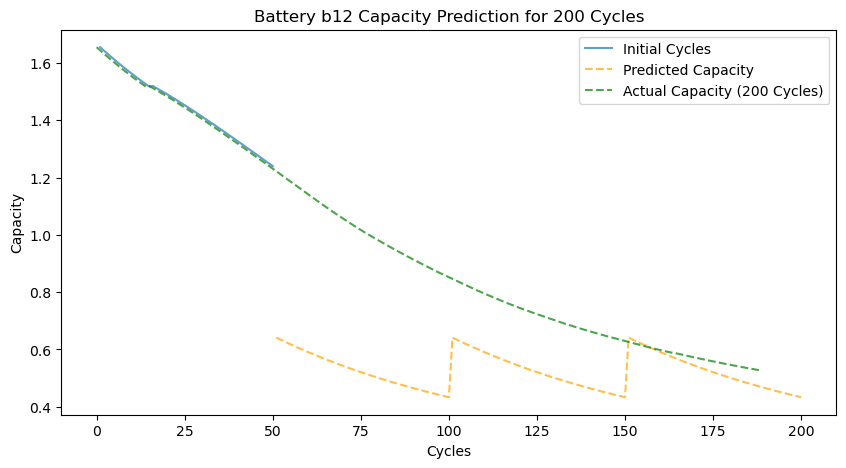

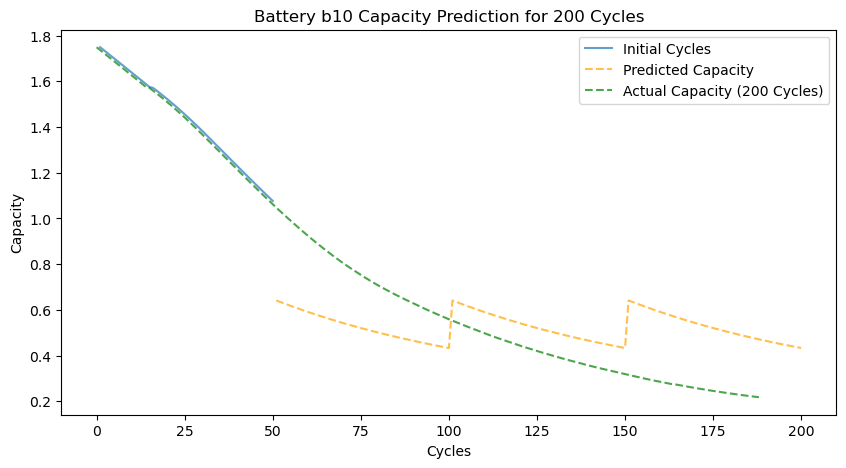

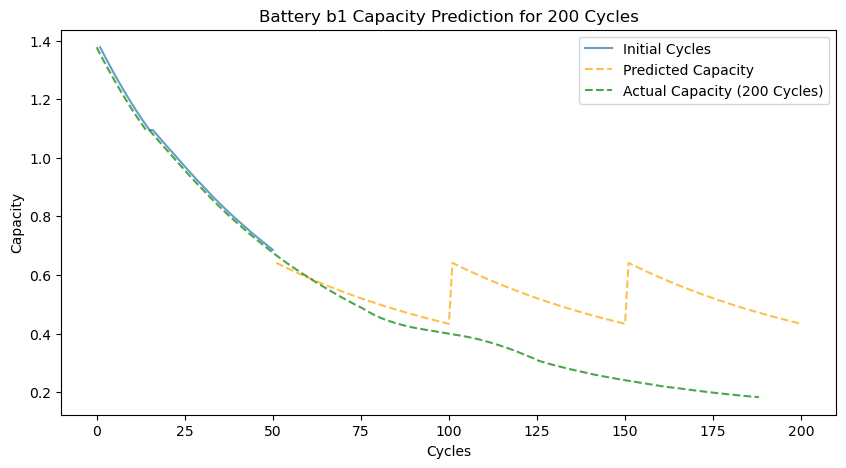

In [121]:
# Prepare the testing data
X_test = []
y_test = []

for battery_id in test_ids:
    battery_data = np.array(qd_capacity_dict[battery_id])
    for i in range(hops, len(battery_data) - forecast_steps):
        X_test.append(battery_data[i - hops:i])
        y_test.append(battery_data[i:i + forecast_steps])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Prediction code
for i, battery_id in enumerate(test_ids):
    battery_data = np.array(qd_capacity_dict[battery_id]).reshape(-1, 1)
    input_sequence = battery_data[:hops, 0]

    predictions = []
    cycle_count = 0  # Initialize cycle count

    while cycle_count < (200 - hops):
        model_input = np.reshape(input_sequence, (1, -1, 1))
        predicted_cycles = model.predict(model_input, verbose=0).flatten()

        predictions.extend(predicted_cycles)
        input_sequence = np.append(input_sequence[len(predicted_cycles):], predicted_cycles)

        cycle_count += len(predicted_cycles)

    combined_capacity = np.concatenate((battery_data[:hops, 0], predictions))

    cycle_indices = np.arange(1, len(combined_capacity) + 1)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(cycle_indices[:hops], battery_data[:hops, 0], label='Initial Cycles', alpha=0.7)
    plt.plot(cycle_indices[hops:200], combined_capacity[hops:200], label='Predicted Capacity', alpha=0.7, linestyle='--', color='orange')
    plt.plot(battery_data[:200, 0], label='Actual Capacity (200 Cycles)', alpha=0.7, linestyle='--', color='green')
    plt.title(f'Battery {battery_id} Capacity Prediction for 200 Cycles')
    plt.xlabel('Cycles')
    plt.ylabel('Capacity')
    plt.legend()
    plt.show()


In [122]:
y_pred = model.predict(X_train)
rmse_train = mean_squared_error(y_pred, y_train)
# results_df.loc["normal_RNN", "train"] = rmse_train
print(rmse_train)

y_pred = model.predict(X_test)
rmse_test = mean_squared_error(y_pred, y_test)
# results_df.loc["normal_RNN", "test"] = rmse_test
print(rmse_test)

 1/28 [>.............................] - ETA: 0s

28/28 [==============================] - 0s 10ms/step
0.06627787383419266
9/9 [==============================] - 0s 9ms/step
0.04782363123260222


In [ ]:
results_df

,train,test
normal_LSTM,0.000417,0.000600
savgol_LSTM,0.000334,0.000414
normal_GRU,0.000414,0.000538
savgol_GRU,0.000417,0.000371
normal_RNN,0.001191,0.001107
savgol_RNN,0.001191,0.001107
